# Проект для курса Я.Практикум, спринт "Принятие решений в бизнесе".  Выбор и тестирование гипотезы с целью увеличения выручки интернет-магазина.


## Цель проекта: 

### Выбрать и протестировать одну из девяти сформированных совместно с отделом маркетинга гипотез по увеличению выручки интернет-магазина.


## Данные: 

***Файл /datasets/hypothesis.csv*** - перечень гипотез и их оценка по нескольким параметрам:

**Hypothesis** — краткое описание гипотезы;

**Reach** — охват пользователей по 10-балльной шкале;

**Impact** — влияние на пользователей по 10-балльной шкале;

**Confidence** — уверенность в гипотезе по 10-балльной шкале;

**Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

***Файл /datasets/orders.csv*** - данные о заказах пользователей

**transactionId** — идентификатор заказа;

**visitorId** — идентификатор пользователя, совершившего заказ;

**date** — дата, когда был совершён заказ;

**revenue** — выручка заказа;

**group** — группа A/B-теста, в которую попал заказ.

***Файл /datasets/visitors.csv*** - данные о посещениях интернет-магазина пользователями

**date** — дата;

**group** — группа A/B-теста;

**visitors** — количество пользователей в указанную дату в указанной группе A/B-теста



## План исследования:

1. [Загрузка данных](#load) 
2. [Предобработка данных](#preprocessing)
3. [Приоритизация гипотез](#prioritization) 
4. [Анализ A/B-теста](#analysis) 
5. [Решение по результатам теста и общие выводы](#decision) 

### 1. Загрузка данных <a id='load'></a>

In [1]:
#Импортируем нужные библиотеки
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.stats as stats
import math as mth

pd.set_option('display.max_columns', None)

In [2]:
#Открываем файлы
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

except:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')

In [3]:
#Изучим общую информацию и посмотрим первые строки
def data_description(df):
    '''функция для вывода данных о датасете -info, describe, первые 5 строк, количество явных дубликатов'''
    result = display(df.info()), display(df.describe()), display(df.head()), 
    display('Количество явных дубликатов:', df.duplicated().sum())
    return result

display('Информация о гипотезах')
data_description(hypothesis)

'Информация о гипотезах'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


'Количество явных дубликатов:'

0

(None, None, None)

In [4]:
display('Информация о заказах')
data_description(orders)

'Информация о заказах'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


'Количество явных дубликатов:'

0

(None, None, None)

In [5]:
display('Информация о посещениях')
data_description(visitors)

'Информация о посещениях'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


'Количество явных дубликатов:'

0

(None, None, None)

**Выводы**

- Пропусков в данных нет
- Явных дубликатов в данных нет
- Выбивающихся данных, вызывающих недоверие, нет
- Необходимо привести названия столбцов в нижний регистр и разделить слова нижним подчеркиванием (для соблюдения единого стиля)
- Необходимо изменить тип данных в столбцах с данными о дате

### 2. Предобработка данных <a id='preprocessing'></a>

In [6]:
#Приведем названия столбцов к единому стилю
hypothesis.columns = hypothesis.columns.str.lower()
display(hypothesis.head(2))

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10


In [7]:
list(orders.columns)

['transactionId', 'visitorId', 'date', 'revenue', 'group']

In [8]:
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})
display(orders.head(2))

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B


In [9]:
#Изменим тип данных в столбцах с датами

visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

display(visitors.info())
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


**Выводы**

- Предобработка проведена, данные готовы к дальнейшей работе

### 3. Приоритизация гипотез <a id='prioritization'></a>

In [10]:
#Посмотрим имеющийся список гипотез и их оценки по параметрам RICE
pd.set_option('max_colwidth', None)
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [11]:
#Применим фреймворк ICE для приоритизации гипотез

hypothesis['ice_score'] = round((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'], 2)
display(hypothesis.sort_values(by='ice_score', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ice_score
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


In [12]:
#Применим фреймворк RICE для приоритизации гипотез

hypothesis['rice_score'] = round((hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'], 2)
display(hypothesis.sort_values(by='rice_score', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ice_score,rice_score
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


**Выводы**

- Согласно расчетам по фреймворку ICE, в приоритете проверка гипотез № 8, 0 и 7 (по убыванию набранных баллов)
- Согласно расчетам по фреймворку RICE, в приоритете проверка гипотез № 7, 2 и 0 (по убыванию набранных баллов)
- Разница в приоритете объясняется подходом к расчетам в фреймворках - RICE, в отличие от ICE, учитывает охват аудитории, на которую повлияют изменения. 

Это очень наглядно можно оценить на гипотезе № 8 "Запустить акцию, дающую скидку на товар в день рождения", которая заняла первое место по оценке ICE. Высокий уровень влияния на пользователей, высокий уровень уверенности в том, что гипотеза серьезно повлияет и средний уровень затрат на проверку гипотезы - все это позволило гипотезе набрать наивысший балл. Но если к расчетам добавить оценку охвата пользователей, которых затронут изменения, гипотеза сразу начинает уступать другим вариантам. День рождения бывает только раз в году, соответственно, во все прочие даты, акция не будет влиять на выручку по каждому конкретному пользователю.	

- В первую очередь, проведем A/B-тест гипотезы, набравшей наибольшее количество баллов при расчете по фреймворку RICE и попавшей в ТОП-3 фреймворка ICE - гипотеза №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

### 4. Анализ A/B-теста <a id='analysis'></a>

Для корректного анализа, убедимся, что были соблюдены критерии успешного А/А теста. По имеющейся у нас сейчас информации, мы можем проверить только то, не повторяются ли id пользователей в разных группах.

In [13]:
#Проверим количество групп
display(orders['group'].unique())
visitors['group'].unique()

array(['B', 'A'], dtype=object)

array(['A', 'B'], dtype=object)

In [14]:
#Убедимся, что пользователи не повторяются в разных группах
group_a = orders[(orders['group'] == 'A')]['visitor_id']
group_b = orders[(orders['group'] == 'B')]['visitor_id']
display('Количество повторяющихся пользователей в обеих группах: ', len(list(set(group_a) & set(group_b))))

'Количество повторяющихся пользователей в обеих группах: '

58

In [15]:
#Выделим повторяющихся пользователей в отдельную группу, посчитаем процент
group_mistake = list(set(group_a) & set(group_b))
display(f"Процент повторяющихся пользователей: {round(len(group_mistake)/len(orders['visitor_id'].unique()) * 100, 2)} %")

'Процент повторяющихся пользователей: 5.63 %'

К сожалению, в данные закралась ошибка - более 5% пользователей попали в обе группы тестирования, эта ситуация недопустима. Придется удалить данные о таких пользователях.

In [16]:
#Обновляем датасет с заказами 
orders = orders.query('visitor_id not in @group_mistake')
group_a = orders[(orders['group'] == 'A')]['visitor_id']
group_b = orders[(orders['group'] == 'B')]['visitor_id']
display('Количество повторяющихся пользователей в обеих группах: ', len(list(set(group_a) & set(group_b))))

'Количество повторяющихся пользователей в обеих группах: '

0

Приступаем к анализу результатов A/B-теста

#### График кумулятивной выручки по группам

In [17]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = (
    dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                    orders['group'] == x['group'])].agg({'date' : 'max', 
                    'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 
                    'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
                    )
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = (
    dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                   visitors['group'] == x['group'])].agg({'date' : 'max', 
                   'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
)
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulative_data.head(5)) 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


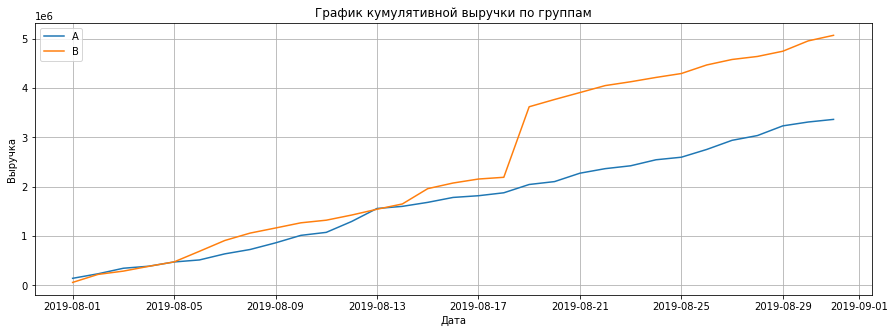

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]



# Строим график выручки группы А
plt.figure(figsize=(15, 5)) 
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')


plt.legend() 
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.show()

**Выводы**

- В группе А выручка равномерно увеличивается в течение всего теста
- График выручки группы В имеет резкий скачок. Это можно объяснить ростом числа заказов или очень дорогими заказами, совершенными в этот период. Мы проверим возможные выбросы позднее.

#### График кумулятивного среднего чека по группам

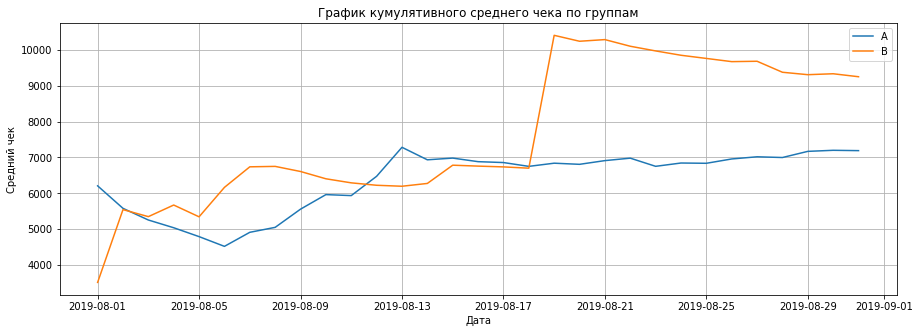

In [19]:
#Построим графики среднего чека по группам

plt.figure(figsize=(15, 5)) 

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Cредний чек')
plt.grid()
plt.show()

**Выводы**

- График группы А неравномерно растет до середины теста, потом устанавливается на одном уровне
- Имеется резкий скачок среднего чека по группе В - это может говорить о крупном заказе в этот период. Далее следует плавное падение.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

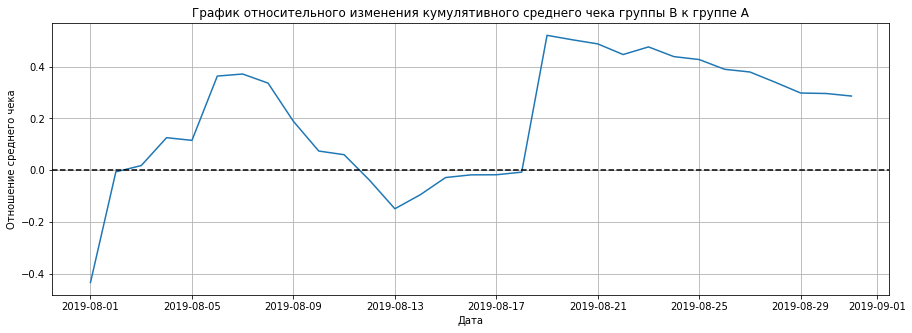

In [20]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = (
    cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)
# cтроим отношение средних чеков
plt.figure(figsize=(15, 5)) 
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/
                                             merged_cumulative_revenue['ordersB'])/
         (merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение среднего чека')
plt.grid()
plt.show()

**Выводы**

- Наблюдаются аномальные скачки в нескольких точках - это говорит о выбросах в заказах в эти даты. С этими данными необходимо поработать глужбе.

#### График кумулятивного среднего количества заказов на посетителя по группам

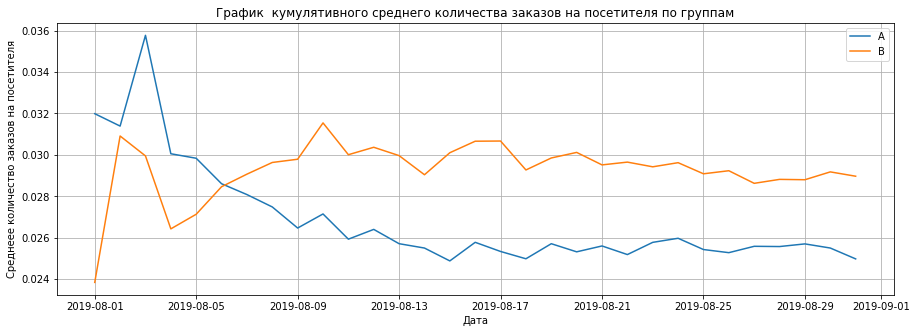

In [21]:
# считаем среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.figure(figsize=(15, 5))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.title('График  кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Cреднеее количество заказов на посетителя')
plt.grid()
plt.show()

**Выводы**

- Имеются резкие скачки в количестве заказов на посетителя в начале теста, позднее оба графика стабилизируются. 
- Показатели группы В стабильно выше группы А.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

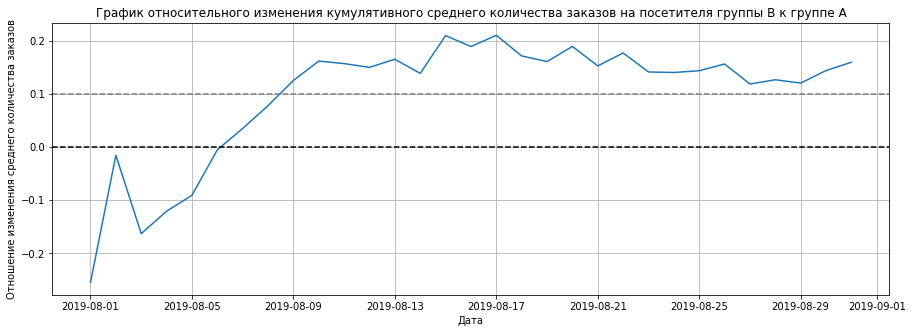

In [22]:
merged_cumulative_conversions = (
    cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], 
                                                   left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)
plt.figure(figsize=(15, 5))
plt.plot(merged_cumulative_conversions['date'], 
         merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1) 
         
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение изменения среднего количества заказов')
plt.grid()
plt.show()

**Выводы**

- Имеются резкие скачки в начале теста.
- Уже после первой недели теста, показатели группы В остаются на стабильном уровне, с приростом более 10% относительно группы А.
- Стоит проанализировать аномалии, возможно они повлияют на результаты теста.

#### Точечный график количества заказов по пользователям. Граница для определения аномальных пользователей

In [23]:
#Посмотрим на максимальное количество заказов по пользователям
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})

orders_by_users.columns = ['visitor_id', 'orders']

display(orders_by_users.sort_values(by='orders', ascending=False).head(10)) 

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


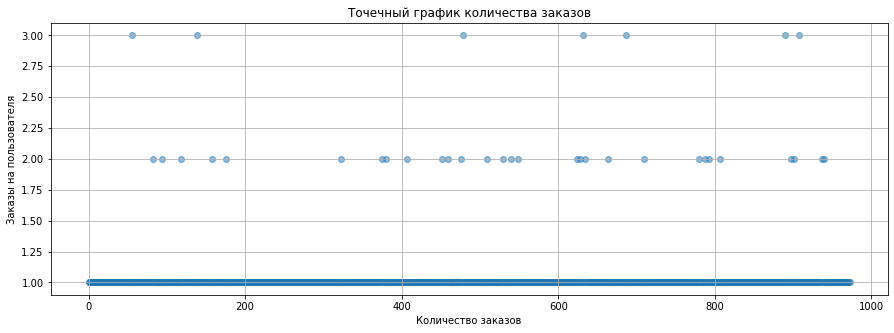

In [24]:
#Построим график рассеяния количества заказов на пользователя
x_values = pd.Series(range(0,len(orders_by_users)))
plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders_by_users['orders'], alpha=0.5) 
plt.title('Точечный график количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Заказы на пользователя')
plt.grid()
plt.show()

In [25]:
#Выберем границу для определения аномальных заказов
display('В выборке не больше 5% пользователей делали заказов более чем: ', np.percentile(orders_by_users['orders'], 95))
display('В выборке не больше 1% пользователей делали заказов более чем: ', np.percentile(orders_by_users['orders'], 99))

'В выборке не больше 5% пользователей делали заказов более чем: '

1.0

'В выборке не больше 1% пользователей делали заказов более чем: '

2.0

**Выводы**

- Подавляющее большинство пользователей совершает только один заказ
- Не более 5% пользователей совершают больше 1 заказа. 
- Не более 1% пользователей совершают больше 2 заказов.
- График рассеяния также наглядно показывает, сколь незначительно число пользователей, совершающих более 1 заказа.
- Определим границу для аномального количества заказов на уровне 95-го перцентиля - 1 заказ на пользователя.

#### Точечный график стоимостей заказов. Граница для определения аномальных заказов

In [26]:
#Проверим, что могло быть причиной всплесков на графиках, посмотрим на максимальные суммы заказов
orders.sort_values('revenue', ascending=False).head(10)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A
949,1347999392,887908475,2019-08-21,60450,A
940,2420050534,4003628586,2019-08-08,58550,B
131,3163614039,2254586615,2019-08-22,53904,A


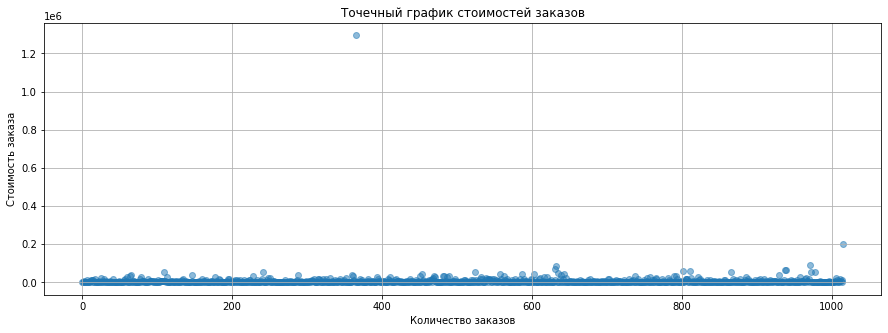

In [27]:
#Построим график рассеяния стоимостей заказов
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders['revenue'], alpha=0.5) 
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказа')
plt.grid()
plt.show()

In [28]:
#Выберем границу для определения аномальных заказов
display('В выборке не более 5% заказов дороже: ', np.percentile(orders['revenue'], 95))
display('В выборке не более 1% заказов дороже: ', np.percentile(orders['revenue'], 99))
display('Медианная стоимость заказов: ',orders['revenue'].median())

'В выборке не более 5% заказов дороже: '

26785.0

'В выборке не более 1% заказов дороже: '

53904.0

'Медианная стоимость заказов: '

2955.0

**Выводы**

- Подтвердились предположения об аномалиях в стоимости заказов - два крупнейших заказа группы В на сумму 1,3 млн и 0,2 млн - сильно выбиваются из всех прочих значений. Все прочие заказы не превышают 92550 руб.
- Не более 5% всех заказов превышают порог в 26785 руб. 
- Не более 1% всех заказов превышают порог в 53904 руб.
- График рассеяния наглядно показывает, что почти все значения находятся на уровне ниже 5000 руб. Расчет медианной стоимости заказов дает точный ответ - 2955 руб.
- Определим границу для аномальных по стоимости заказов на уровне 95-го перцентиля - 26785 руб.

#### Расчет статистической значимости различий между группами по «сырым» данным

В данных есть выбросы и мы вычислили границы для их определения. Подготовим данные для дальнейших расчетов.

In [29]:
#Рассчитаем количество пользователей в выбранную дату в группе A
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

#Рассчитаем количество пользователей до выбранной даты включительно в группе A
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

#Рассчитаем количество пользователей в выбранную дату в группе В

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

#Рассчитаем количество пользователей до выбранной даты включительно в группе В
visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

#Рассчитаем для группы А: orders_per_date_a — количество заказов в выбранную дату в группе A;
#revenue_per_date_a — суммарная выручка в выбранную дату в группе A;
#orders_cummulative_a — суммарное число заказов до выбранной даты включительно в группе A;
#revenue_cummulative_a — суммарная выручка до выбранной даты включительно в группе A;

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

#Аналогично для группы В:

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

#Объединим в общую таблицу

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5)) 

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезы:

**Нулевая Н0**: различий в среднем количестве заказов между группами нет 

**Альтернативная Н1**: различия в среднем между группами есть

Уровень значимости P-value = 0,05

In [30]:
#Посчитаем статистическую значимость различия в среднем количестве заказов между группами
#Создадим переменные для двух групп со столбцами ['visitor_id', 'orders']. 
#В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов

orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

#Объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов. 
#Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

sample_a = (
    pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - 
            len(orders_by_users_a['orders'])), name='orders')],axis=0)
)
sample_b = (
    pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() -
            len(orders_by_users_b['orders'])), name='orders')],axis=0)
)

#Проводим проверку критерием Манна-Уитни

display('p-value: {0:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))

display('Отношение группы В к А: {0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

'p-value: 0.011'

'Отношение группы В к А: 0.160'

**Выводы**

- Полученное значение 0,011 меньше уровня значимости P-value,следовательно мы отвергаем гипотезу Н0 о том, что различий в среднем количестве заказов между группами нет:

**По «сырым» данным есть статистически значимые различия в среднем числе заказов групп A и B**

- Относительный выигрыш группы B равен 16%.

#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Теперь проверим статистическую значимость различий в среднем чеке между группами. 
Сформулируем гипотезы:

**Нулевая Н0**: различий в среднем чеке между группами нет 

**Альтернативная Н1**: различия в среднем чеке между группами есть

Уровень значимости P-value = 0,05

In [31]:
#Передадим критерию mannwhitneyu() данные о выручке с заказов
display('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

#Найдём относительные различия в среднем чеке между группами
display('Отношение группы В к А: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

'p-value: 0.829'

'Отношение группы В к А: 0.287'

**Выводы**

- Полученное значение 0,829 значительно больше уровня значимости P-value,следовательно нет оснований отвергать гипотезу Н0 о том, что различий в среднем чеке между группами нет.

**По «сырым» данным нет статистически значимых различий в среднем чеке заказа групп A и B**

- Относительный выигрыш по среднему чеку группы B равен 28,7%. Эта разница может быть объяснена аномалиями - дорогими заказами, выбивающимися из средних значений. Ранее, на графике кумулятивного среднего чека мы видели резкий всплекс, а потом плавное падение в группе В. Мы проверим наше предположение о выбросах, очистив данные от аномалий позднее. 

#### Расчет статистической значимости различий между группами по  «очищенным» данным

Проверим, как повлияет на результат очистка данных от аномальных значений.

Составим список аномальных пользователей по выбранным ранее критериям: 
- Пользователь совершил более 1 заказа 

и/или
- Пользователь совершил заказ дороже 26785 рублей. 

In [32]:
#Отбираем пользователей с количеством заказов более 1
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 1]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 1]['visitor_id'],
    ],
    axis=0,
)

#Отбираем пользователей с заказами стоимостью более 26785 рублей
users_with_expensive_orders = orders[orders['revenue'] > 26785]['visitor_id']

#Создаем общий список аномальных пользователей
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

#Проверяем, считаем количество
display(abnormal_users.head(2))
display('Всего аномальных пользователей: ', abnormal_users.shape[0]) 

568     113298937
1099    148427295
Name: visitor_id, dtype: int64

'Всего аномальных пользователей: '

86

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Проверим, как 86 аномальных пользователей повлияли на результаты теста.

Сформулируем гипотезы:

**Нулевая Н0**: различий в среднем количестве заказов на посетителя между группами по «очищенным» данным нет 

**Альтернативная Н1**: различия в среднем количестве заказов на посетителя между группами по «очищенным» данным есть

Уровень значимости P-value = 0,05

In [33]:
#Подготовим выборки количества заказов по пользователям по группам теста:

sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#Применим статистический критерий Манна-Уитни к полученным выборкам:

display('p-value: {0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
display('Отношение группы В к А: {0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)) 

'p-value: 0.016'

'Отношение группы В к А: 0.174'

**Выводы**

- Полученное значение 0,016 меньше уровня значимости P-value,следовательно мы отвергаем гипотезу Н0 о том, что различий в среднем количестве заказов на посетителя между группами по «очищенным» данным нет:

**По «очищенным» данным есть статистически значимые различия в среднем числе заказов групп A и B**

- Относительный выигрыш группы B равен 17.4%.

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезы:

**Нулевая Н0**: различий в среднем чеке заказа между группами по «очищенным» данным нет 

**Альтернативная Н1**: различия в среднем чеке заказа между группами по «очищенным» данным есть

Уровень значимости P-value = 0,05

In [34]:
display(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

display(
    'Отношение группы В к А: {0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

'p-value: 0.727'

'Отношение группы В к А: -0.034'

**Выводы**

- Полученное значение 0,727 значительно больше уровня значимости P-value,следовательно нет оснований отвергать гипотезу Н0 о том, что различий в среднем чеке между группами нет.

**По «очищенным» данным нет статистически значимых различий в среднем чеке заказа групп A и B**

- Относительный проигрыш по среднему чеку группы B равен 3.4% - подтвердились догадки о том, что аномалии (дорогие заказы) в сырых данных искажали картину. Разница слишком мала, чтобы признать ее статистически значимой, ее не стоит принимать во внимание.

### 5. Решение по результатам теста и общие выводы <a id='decision'></a>


- Мы убедились, что имеются статистически значимые различия по среднему числу заказов между группами А и В по сырым и по очищенным данным. Т.е. разница не случайна, действительно имеет место быть преимущество у группы B (увеличение среднего числа заказов на 16-17%)

- По среднему чеку статистически значимых различий нет ни по сырым, ни по очищенным данным.

- Было видно преимущество группы В на графике кумулятивного среднего чека, но после очистки данных, мы убедились в том, что разница имела место быть из-за аномальных значений (дорогие заказы в период теста), их не стоит принимать во внимание.

- **Рекомендуется остановить тест и признать его успешным** - гипотеза подтвердилась и привела к росту числа заказов. Средний чек при этом не изменился.

**Технические рекомендации**:

- Были обнаружены повторяющиеся id пользователей в разных группах. 58 id, это 5.63% от общего числа. Эти данные были удалены и не принимали участия в дальнейшем анализе, но учитывая найденную ошибку, **рекомендуется** в будущем внимательнее подходить к А/А тестированию и проверять, что:

1. Количество пользователей в различных группах различается не более, чем на 1%;
2. Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
3. Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
4. Попавший в одну из групп посетитель остаётся в этой группе до конца теста.